In [2]:
words = open("../names.txt", "r").read().splitlines()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
b = {}
for w in words:
    chars = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chars, chars[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [5]:
sorted(b.items(), key=lambda k: k[1], reverse=True)

[(('a', '<E>'), 6950),
 (('n', '<E>'), 6830),
 (('a', 'n'), 5538),
 (('<S>', 'a'), 4460),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3342),
 (('e', 'l'), 3304),
 (('n', 'a'), 3091),
 (('r', 'i'), 3056),
 (('<S>', 'k'), 3005),
 (('l', 'e'), 2964),
 (('e', 'n'), 2714),
 (('l', 'a'), 2667),
 (('m', 'a'), 2648),
 (('<S>', 'm'), 2602),
 (('a', 'l'), 2565),
 (('l', 'i'), 2553),
 (('i', 'a'), 2519),
 (('i', '<E>'), 2494),
 (('o', 'n'), 2459),
 (('<S>', 'j'), 2456),
 (('h', '<E>'), 2411),
 (('r', 'a'), 2402),
 (('a', 'h'), 2332),
 (('h', 'a'), 2252),
 (('i', 'n'), 2173),
 (('y', 'a'), 2143),
 (('<S>', 's'), 2100),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2032),
 (('e', 'r'), 2021),
 (('n', 'n'), 1919),
 (('y', 'n'), 1856),
 (('n', 'i'), 1765),
 (('k', 'a'), 1763),
 (('r', 'e'), 1724),
 (('<S>', 'd'), 1707),
 (('i', 'e'), 1687),
 (('<S>', 'r'), 1680),
 (('a', 'i'), 1650),
 (('a', 'm'), 1646),
 (('<S>', 'l'), 1618),
 (('l', 'y'), 1588),
 (('<S>', 'e'), 1559),
 (('<S>', 'c'), 1550),
 (('j', 'a'), 1507),
 (

In [6]:
import torch
import numpy

In [7]:
a = torch.zeros((3, 5), dtype=torch.int32)

In [8]:
a

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

In [9]:
a.dtype

torch.int32

In [10]:
chars = []
for w in words:
    for c in w:
        if c not in chars:
            chars.append(c)

In [11]:
len(chars)

32

In [12]:
N = torch.zeros((33, 33), dtype=torch.int32)

In [13]:
characters = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(characters)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [14]:
for w in words:
    chars = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

(np.float64(-0.5), np.float64(32.5), np.float64(32.5), np.float64(-0.5))

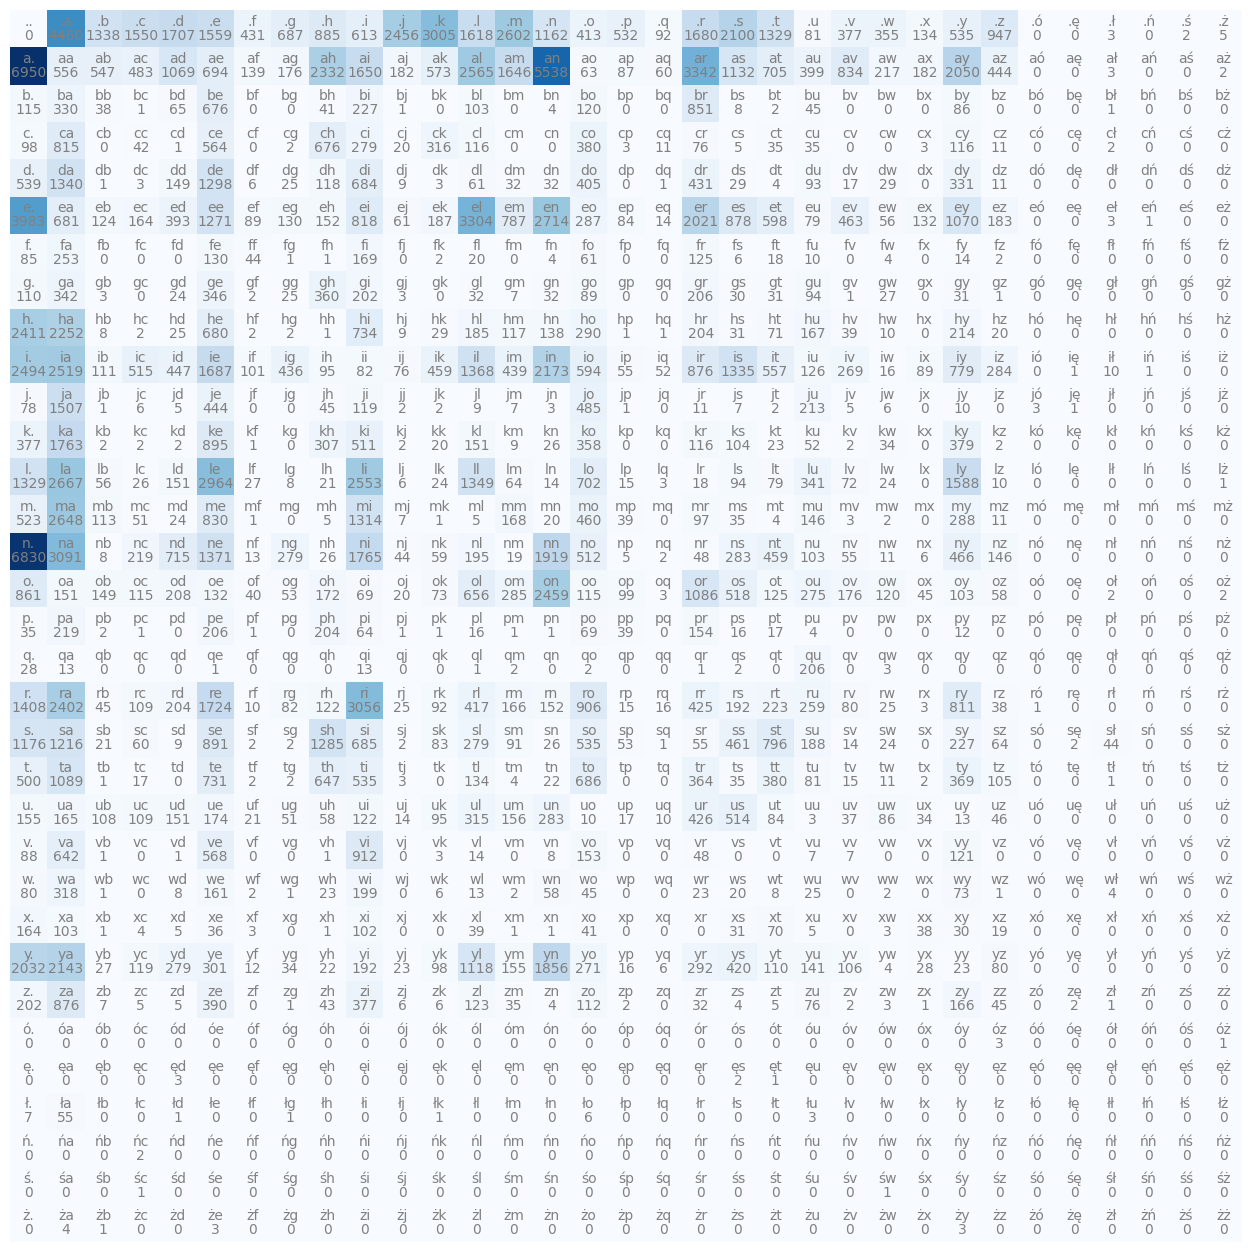

In [16]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(33):
    for j in range(33):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off')

In [17]:
N[0].shape

torch.Size([33])

In [30]:
P = (N+1).float()
P /= P.sum(1, keepdim=True)


In [31]:
generator = torch.Generator().manual_seed(2147483647)
for i in range(20):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=generator).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolia.
s.
tee.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.


In [34]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n+=1
        # print(f'{ch1}{ch2} {prob:.4f} {logprob:.4f}')
print(f'Log likelihood: {log_likelihood:.4f}')
nll = -log_likelihood
print(f'Negative log likelihood: {nll:.4f}')
print(f'Normalized negative log likelihood: {nll/n:.4f}')

Log likelihood: -573785.9375
Negative log likelihood: 573785.9375
Normalized negative log likelihood: 2.4621
